# Introduction

## Business Objective

To help farmers optimize their crop yield, we have developed a predictive model that helps **identify which crop is best to grow in specific soil and climate conditions**.

The model uses a Crop Recommendation dataset available on Keggle. The data contains environmental and soil attributes essential for recommending the optimal crop type.

## Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
from scipy.stats import pearsonr

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.inspection import permutation_importance

import pickle
import joblib

# Data

## Description

This dataset was build by augmenting datasets of rainfall, climate and fertilizer data available for India.

The following data is included:
* N - ratio of Nitrogen content in soil
* P - ratio of Phosphorous content in soil
* K - ratio of Potassium content in soil
* temperature - temperature in degree Celsius
* humidity - relative humidity in %
* ph - ph value of the soil
* rainfall - rainfall in mm

**Data source**

Data is sourced from Kaggel. The Kaggel community is using this dataset largely for learning.

**Data limitations**
* The dataset is India-specific and may not generalize globally.
* It assumes farmers can measure N, P, K, pH, and other features, which may not always be feasible in practice.
* The dataset reflects a static snapshot and does not capture seasonal, regional, or long-term soil fertility changes.

## Load

In [80]:
data_raw = pd.read_csv('../data/Crop_recommendation.csv')
data_raw.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [81]:
# create a backup of the raw data
data_raw_backup = data_raw.copy(deep=True)

# Explanatory Data Analysis

Data preparation steps included:
* Review data types and data to identify inconsistencies (e.g. negative values)
* Checking for missing values and handling them *(none were found)*
* Removing duplicates
* Verifying data types and correcting inconsistencies
* Examining outliers and deciding whether to keep or remove them

These steps ensure that the dataset is consistent and ready for model training.

In [82]:
print(f"Original column names: {list(data_raw.columns)}")
# copy raw data into a new df to avoid modifying the original data
data = data_raw.copy(deep=True)
# replace N, P, K columns with nitrogen, phosphorous, potassium
data = data.rename(columns={"N": "nitrogen", "P": "phosphorous", "K": "potassium", "label": "crop"})
print(f"Modified column names: {list(data.columns)}")
data.head(1)

Original column names: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Modified column names: ['nitrogen', 'phosphorous', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall', 'crop']


,nitrogen,phosphorous,potassium,temperature,humidity,ph,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice


### Basic info & high level data review

In [83]:
print("Number of rows and columns:", data.shape)
data.drop_duplicates(inplace=True)
print("Number of rows and columns after removing duplicates:", data.shape)

Number of rows and columns: (2200, 8)
Number of rows and columns after removing duplicates: (2200, 8)


-> No duplicated rows were found

In [84]:
print("\nData basic info:\n")
data.info()


Data basic info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nitrogen     2200 non-null   int64  
 1   phosphorous  2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


-> Based on the above we can see we have 7 numerical and 1 categorical features, which is the target variable (crop label)


### Null values and data ranges

In [85]:
# NULL values
data.isna().sum()

nitrogen       0
phosphorous    0
potassium      0
temperature    0
humidity       0
ph             0
rainfall       0
crop           0
dtype: int64

-> We can see there are no NULL values

In [86]:
print("Data basic statistics of numerical features:")
data.describe().T.round()

Data basic statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
nitrogen,2200.0,51.0,37.0,0.0,21.0,37.0,84.0,140.0
phosphorous,2200.0,53.0,33.0,5.0,28.0,51.0,68.0,145.0
potassium,2200.0,48.0,51.0,5.0,20.0,32.0,49.0,205.0
temperature,2200.0,26.0,5.0,9.0,23.0,26.0,29.0,44.0
humidity,2200.0,71.0,22.0,14.0,60.0,80.0,90.0,100.0
ph,2200.0,6.0,1.0,4.0,6.0,6.0,7.0,10.0
rainfall,2200.0,103.0,55.0,20.0,65.0,95.0,124.0,299.0


-> Based on the above we cannot say anything about outliers, data-ranges seem fine. We will add visualization / distributions to further investigate the presence of outliers

In [87]:
print("Data basic statistics of target features:")
data.describe(include='object').T

Data basic statistics of target features:


,count,unique,top,freq
crop,2200,22,rice,100


Split numercial and categorical columns (extract target variable)

In [88]:
# split numerical and categorical columns
numerical_columns = data.select_dtypes(include='number').columns
categorical_columns = data.select_dtypes(include='object').columns
# define target variable
target_variable = 'crop'

### Distribution - categorical variables

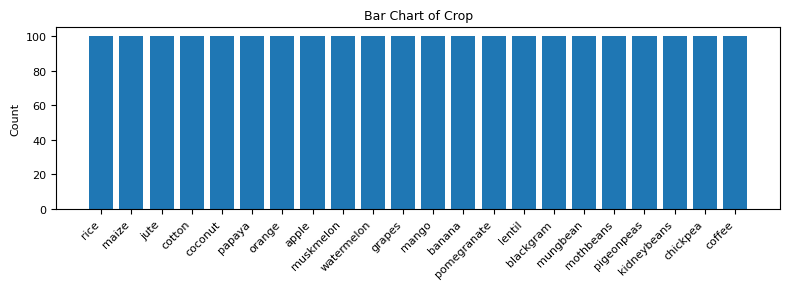

Crop label - percentage of each category value with respect to total:


crop
rice           4.55
maize          4.55
jute           4.55
cotton         4.55
coconut        4.55
papaya         4.55
orange         4.55
apple          4.55
muskmelon      4.55
watermelon     4.55
grapes         4.55
mango          4.55
banana         4.55
pomegranate    4.55
lentil         4.55
blackgram      4.55
mungbean       4.55
mothbeans      4.55
pigeonpeas     4.55
kidneybeans    4.55
chickpea       4.55
coffee         4.55
Name: proportion, dtype: float64

In [89]:
# visualize the distribution of the target variable
fig = plt.figure(figsize=(8, 3))

value_counts = data['crop'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title(f'Bar Chart of Crop', fontsize=9)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(value_counts.index)), value_counts.index, rotation=45, ha='right', fontsize=8)
plt.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

print("Crop label - percentage of each category value with respect to total:")
np.round(data['crop'].value_counts(normalize=True)*100, 2)

-> From the above we can see we have equal representation of each category within the target variable, which means the data is well balanced *(no over-/under-sampling will be needed)*

### Distribution - numerical features

Let's now look at feature distributions, which could show us if outliers are present, but most importantly will be helpful in the identification of the right feature transformation and scaling method.

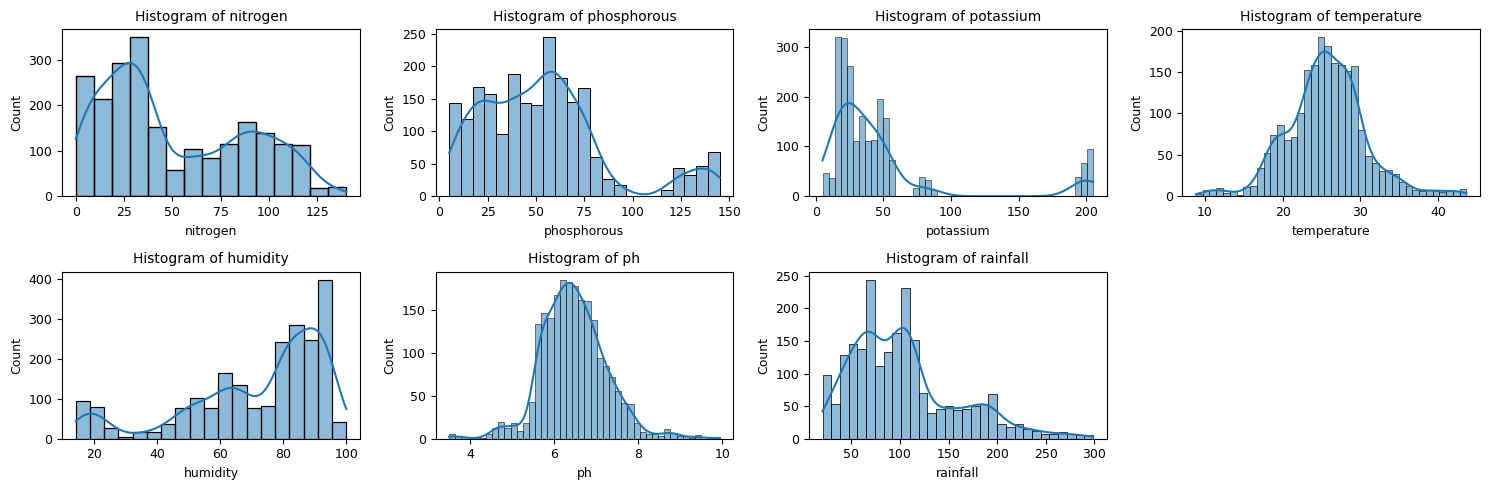

In [90]:
# histogram to identify distributions
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for i, col in enumerate(data[numerical_columns]):
    sns.histplot(data[col], kde=True, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'Histogram of {col}', fontsize=10)
    ax[i//4, i%4].tick_params(axis='y', labelsize=9)
    ax[i//4, i%4].tick_params(axis='x', labelsize=9)
    ax[i//4, i%4].set_ylabel('Count', fontsize=9)
    ax[i//4, i%4].set_xlabel(col, fontsize=9)

# hide unused axes
total_plots = len(numerical_columns)
for j in range(total_plots, 2*4):
    ax[j//4, j%4].set_visible(False)

plt.tight_layout()
plt.show()

-> Looking at the above charts, we do not really see clear outliers. There are some long tails, e.g. phosphorous, potassium *(the latter one could be considered as having outliers)*, however these are driven by different needs of different crops. Below we have displayed histograms by crop-type and one can clearly see that the distributions are more compact (smaller value ranges per crop).

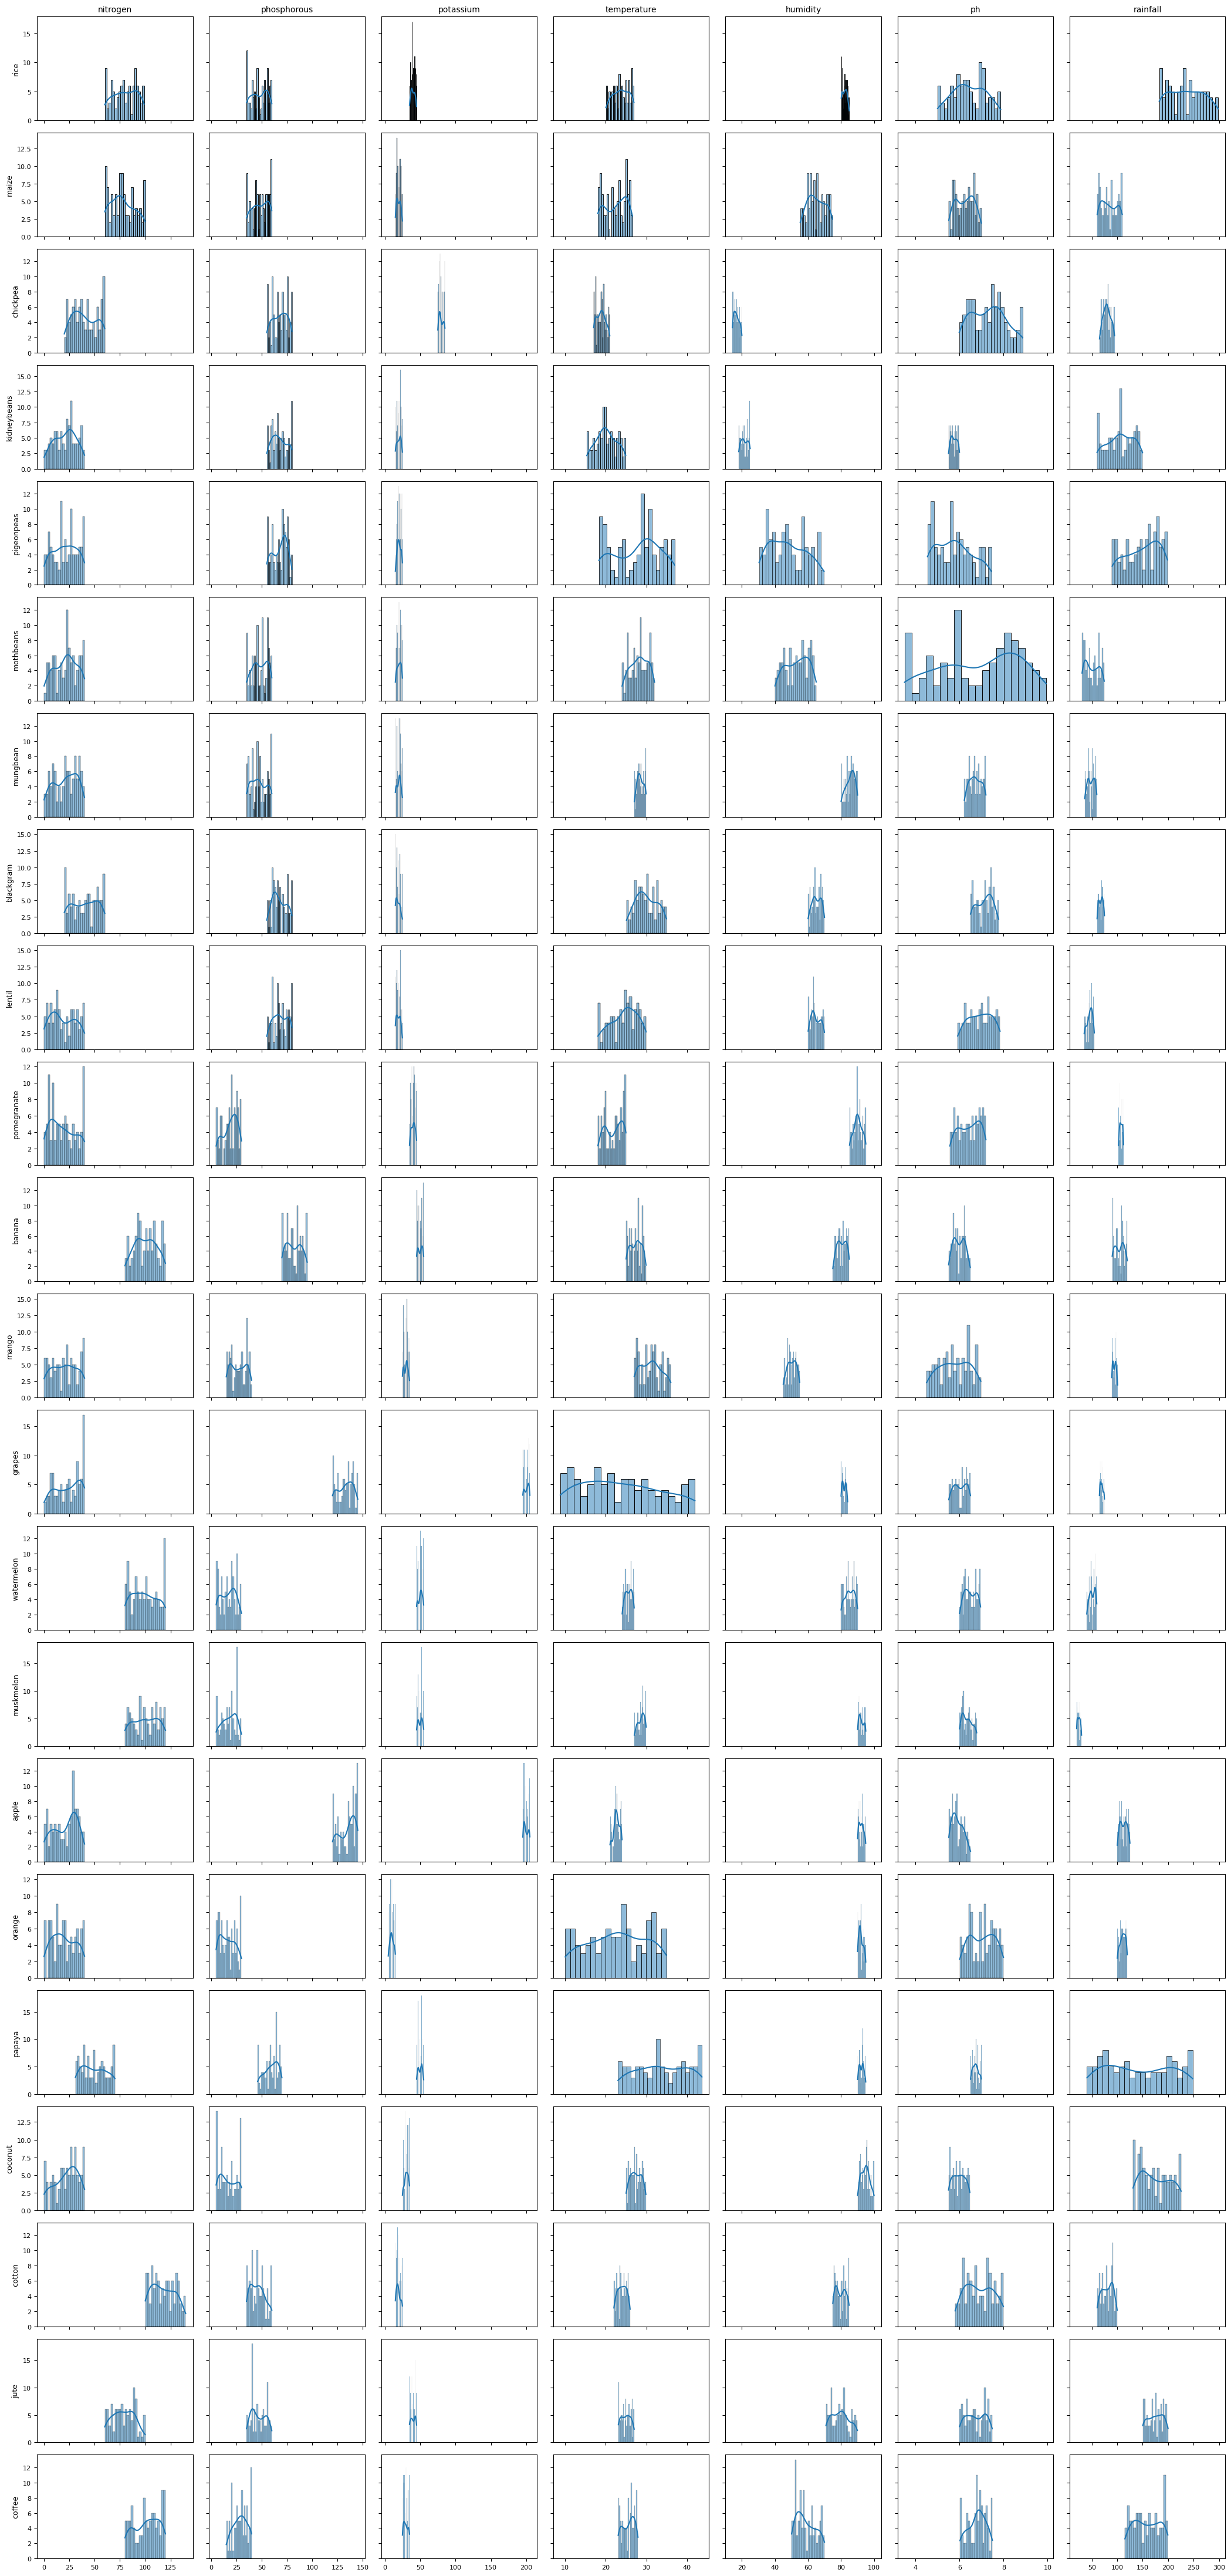

In [91]:
# Feature distribution by crop type
unique_crops = data['crop'].unique()
num_crops = len(unique_crops)
num_features = len(numerical_columns)

fig, axes = plt.subplots(num_crops, num_features, figsize=(3*num_features, 2*num_crops), sharex='col', sharey='row')

for row_idx, crop in enumerate(unique_crops):
    crop_data = data[data['crop'] == crop]
    for col_idx, feature in enumerate(numerical_columns):
        ax = axes[row_idx, col_idx]
        sns.histplot(crop_data[feature], kde=True, ax=ax, bins=20, color='tab:blue')
        if row_idx == 0:
            ax.set_title(feature, fontsize=10)
        if col_idx == 0:
            ax.set_ylabel(crop, fontsize=9)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

Distribution-wise we observe the following:
1) Nitrogen - multi-modal, somewhat spread across the range
    * suggested transformation: StandardScaler *(mainly because the data isnt extremly skewed)*
2) Phosphorous - right-skewed with long tail
    * suggested transformation: Log transformation to normalize before scaling with StandardScaler
3) Potassium - highly-skewed to the right with heavy tail
    * suggested transformation: Log transformation then StandardScaler
4) Temperature - bell-shaped distribution, approx. Gaussian
    * suggested transformation: StandardScaler
5) Humidity - bimodal with peaks
    * suggested transformation: MinMaxScaller
6) Ph - bell-shaped
    * suggested transformations: StandardScaler
7) Rainfall - right-skewed with tail
    * suggested transformation: Log transformation then StandardScaler

-> Nothing specifically stands out from the charts above, apart from the fact that we see different feature values for different crops, which would mean differnt crop needs different conditions and that this data might be a good features set to predict best crop to grow.

In fact, lets check (1) correlation between each feature and crop-type as well as (2) box-plot of each feature by crop-type. This will help us understad better the strength of the relationship between each feature and crop-type

### Correlations - label vs features

(1) Eta squared correlations between each feature and crop-type

In [92]:
# function to calculate correlation ratio (eta squared) between a categorical variable and a numerical variables
def correlation_ratio(categories, measurements):
    if not np.issubdtype(categories.dtype, np.number):
        le = LabelEncoder()
        categories = le.fit_transform(categories)
    categories = np.array(categories)
    measurements = np.array(measurements)
    
    grand_mean = np.mean(measurements)
    ss_between = 0
    ss_total = np.sum((measurements - grand_mean) ** 2)
    
    for cat in np.unique(categories):
        cat_measurements = measurements[categories == cat]
        n_cat = len(cat_measurements)
        cat_mean = np.mean(cat_measurements)
        ss_between += n_cat * (cat_mean - grand_mean) ** 2
    
    eta_squared = ss_between / ss_total if ss_total != 0 else 0
    return eta_squared

# calculate eta squared for each numerical feature vs crop-type
eta2_results = {}
for feature in numerical_columns:
    eta2 = correlation_ratio(data['crop'], data[feature])
    eta2_results[feature] = eta2

eta2_df = pd.DataFrame(list(eta2_results.items()), columns=['Feature', 'Eta Squared'])
print("Eta Squared of 1 indicates a perfect association between crop type and the feature.")
print(eta2_df.round(3))

Eta Squared of 1 indicates a perfect association between crop type and the feature.
       Feature  Eta Squared
0     nitrogen        0.896
1  phosphorous        0.948
2    potassium        0.996
3  temperature        0.496
4     humidity        0.968
5           ph        0.368
6     rainfall        0.854


-> We can see that the correlation coefficient eta squared is close to 1 for almost all features. This means all these features strongly correlated with the target variable. This indicate these features should have a strong predictive power for predicting the best crop type to grow.
Temperature and Ph seem to be the two feature that are least correlated with the crop-type, but nevertheless somehow correlated

(2) Box-plot of each feature by crop-type

Each chart represents boxplot of a numerical feature grouped and coloured by crop type.


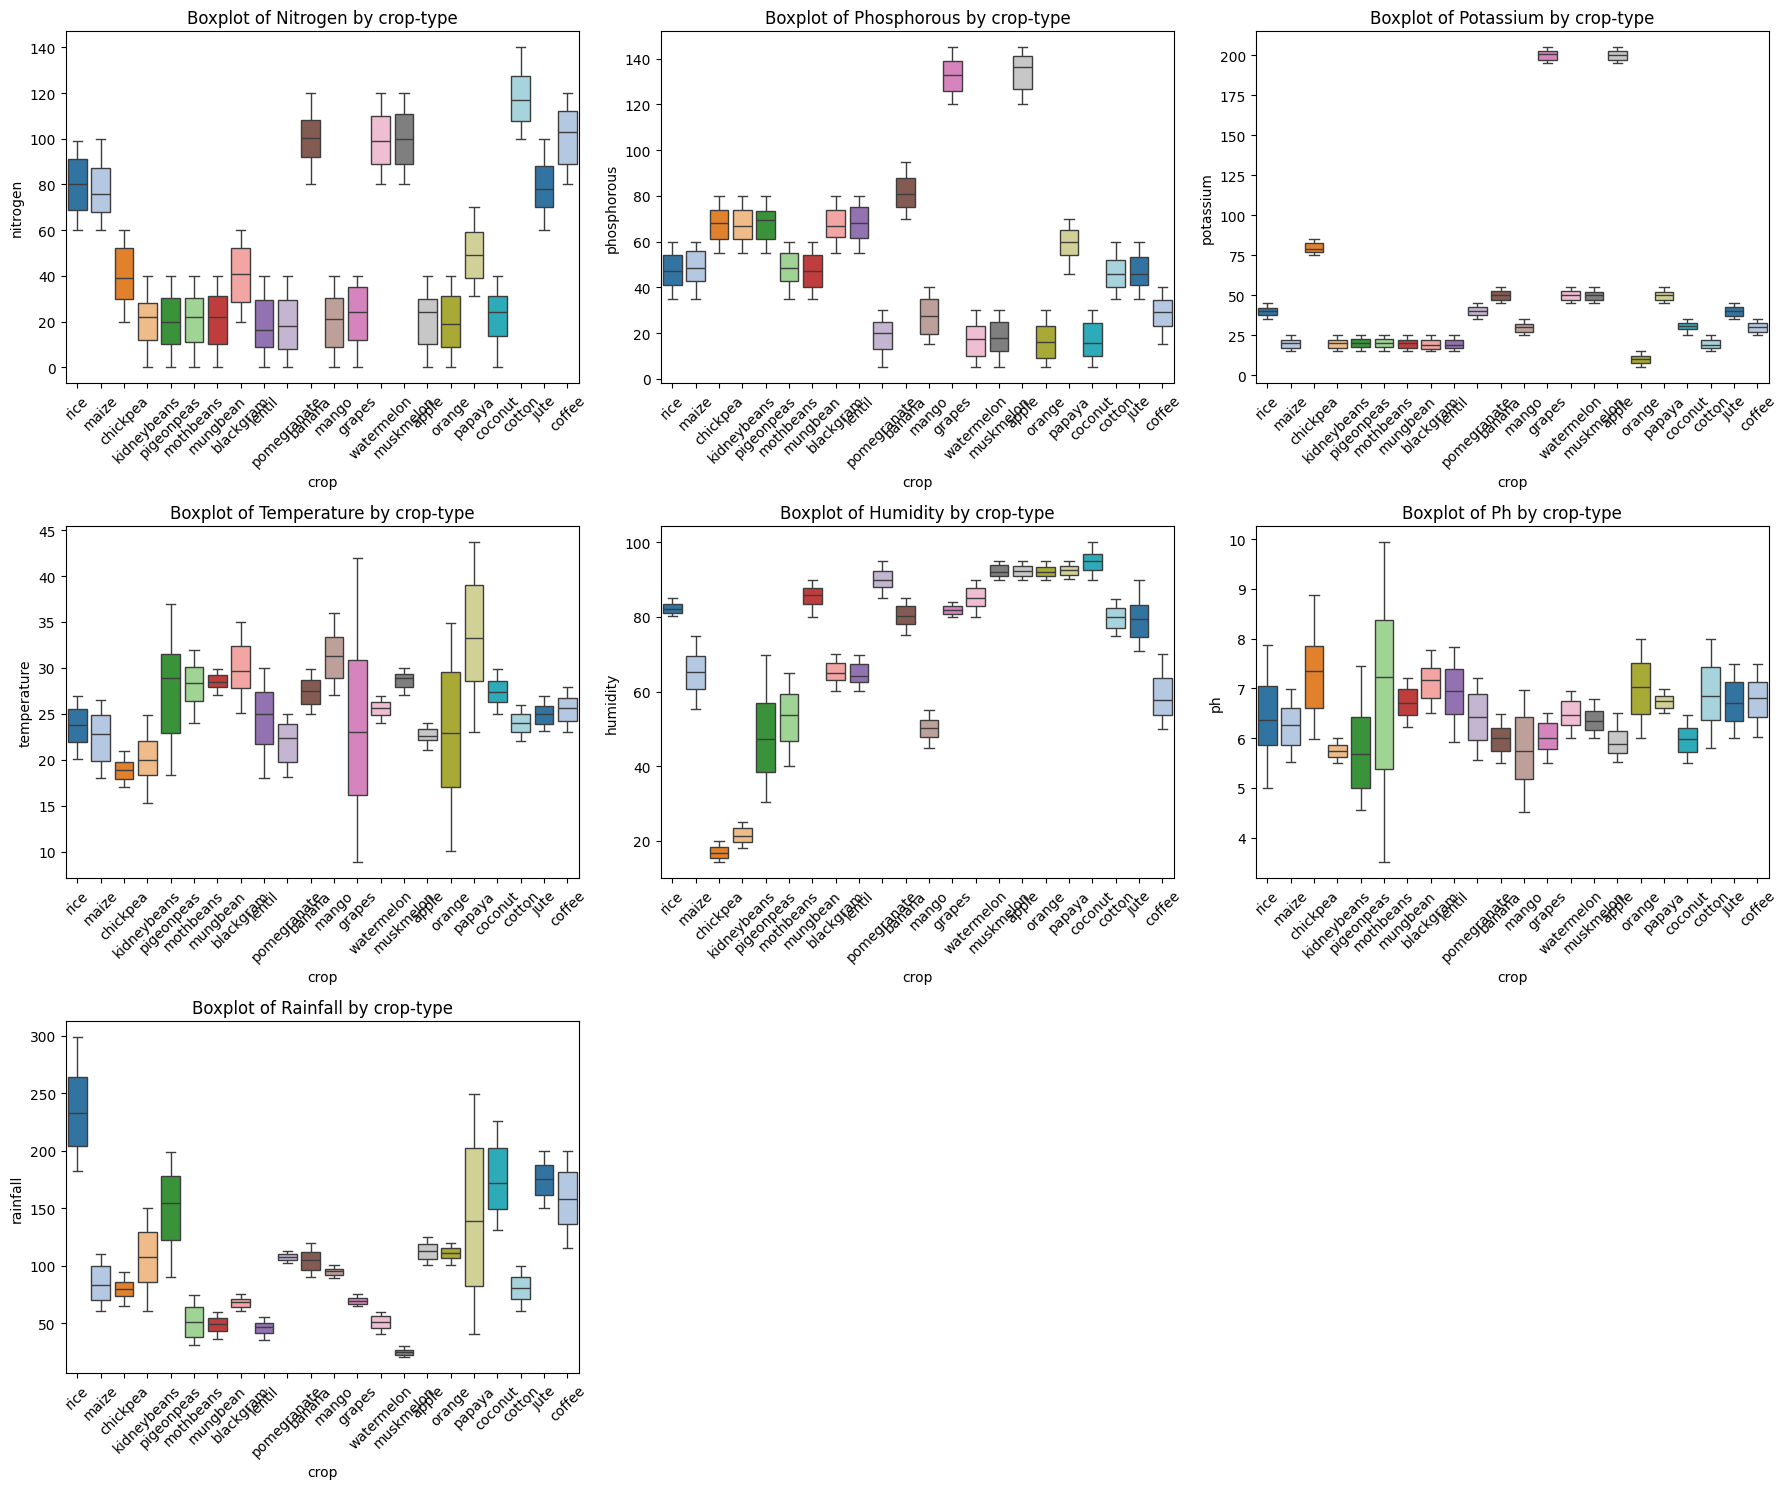

In [93]:
print("Each chart represents boxplot of a numerical feature grouped and coloured by crop type.")
fig, ax = plt.subplots(3, 3, figsize=(18, 15))

for i, col in enumerate(numerical_columns):
    sns.boxplot(x='crop', y=col, data=data, ax=ax[i//3, i%3], hue='crop', palette='tab20', legend=False)
    ax[i//3, i%3].set_title(f'Boxplot of {col.title()} by crop-type')
    ax[i//3, i%3].tick_params(axis='x', rotation=45)

# Hide unused axes
total_plots = len(numerical_columns)
for j in range(total_plots, 9):
    ax[j//3, j%3].set_visible(False)

plt.tight_layout()
plt.show()


-> The above displayed box-plots indeed show different ranges of feature's values depending on a crop-type. For instance looking at:
* Potassium - Mango and Muskmelon crops prefer much higher Potassium levels compared to other crops.
* Rainfall - we can see Rice crop prefers areas with high Rainfall, whereas Watermelon crop prefers areas with low Rainfall.

This further highlights the relationship between features and crop-type, which is a good indicator, i.e. this features dataset could be a good dataset to predict best crop-type.

Before we move to correlations within features, let's investigate and potentially eliminate outliers

### Outliers - features

Given we have seen feature values vary significantly across crop-types, conducting a global outlier analysis may lead to misleading results. Observations that appear to be outliers when viewed across all crops collectively, could in fact be entirely normal within the context of a specific crop. For instance, coming back to our Rainfall example, we can see rainfall levels are much higher for Rice compared to other crops. While these observations could have been perceived as outliers in a global sense, they are expected when analyzed within the Rice crop-type.

Therefore, we will perform features outlier analysis on the crop-level. The initial box-plots showns above do not suggest any strong presence of outliers. To confirm this quantitatively, we will apply the standard appraoch of identifying values lying outside the +/- 1.5 IQR range, as it is commonly used in practice.

In [94]:
# outlier analysis using IQR for each numerical feature by crop-type
outlier_cnt = {}
outlier_idx = {}

for crop in unique_crops:
    crop_data = data[data['crop'] == crop]
    outlier_cnt[crop] = {}
    outlier_idx[crop] = {}
    for feature in numerical_columns:
        Q1 = crop_data[feature].quantile(0.25)
        Q3 = crop_data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = crop_data[(crop_data[feature] < lower_bound) | (crop_data[feature] > upper_bound)][feature]
        outlier_cnt[crop][feature] = outliers.shape[0]
        outlier_idx[crop][feature] = outliers.index.tolist()

outlier_cnt_df = pd.DataFrame.from_dict(outlier_cnt, orient='index')
print(f'Number of outliers overall: {outlier_cnt_df.sum().sum()}')
outlier_cnt_df


Number of outliers overall: 0


,nitrogen,phosphorous,potassium,temperature,humidity,ph,rainfall
rice,0,0,0,0,0,0,0
maize,0,0,0,0,0,0,0
chickpea,0,0,0,0,0,0,0
kidneybeans,0,0,0,0,0,0,0
pigeonpeas,0,0,0,0,0,0,0
mothbeans,0,0,0,0,0,0,0
mungbean,0,0,0,0,0,0,0
blackgram,0,0,0,0,0,0,0
lentil,0,0,0,0,0,0,0
pomegranate,0,0,0,0,0,0,0


-> Based on the above analysis we can state that there are no outliers and we can therefore proceed with the current full dataset

Let's now investigate correlations between features to see if there are many features that are strongly correlated and potentially need to be removed 

### Correlations - features

**Scatter plots**

We will look at scatter-plots to see if there is any clear correlation between two variables (we would then see a "line" (not necessarily linear) formed by the dots). The scatter plot values are coloured by the label (crop).

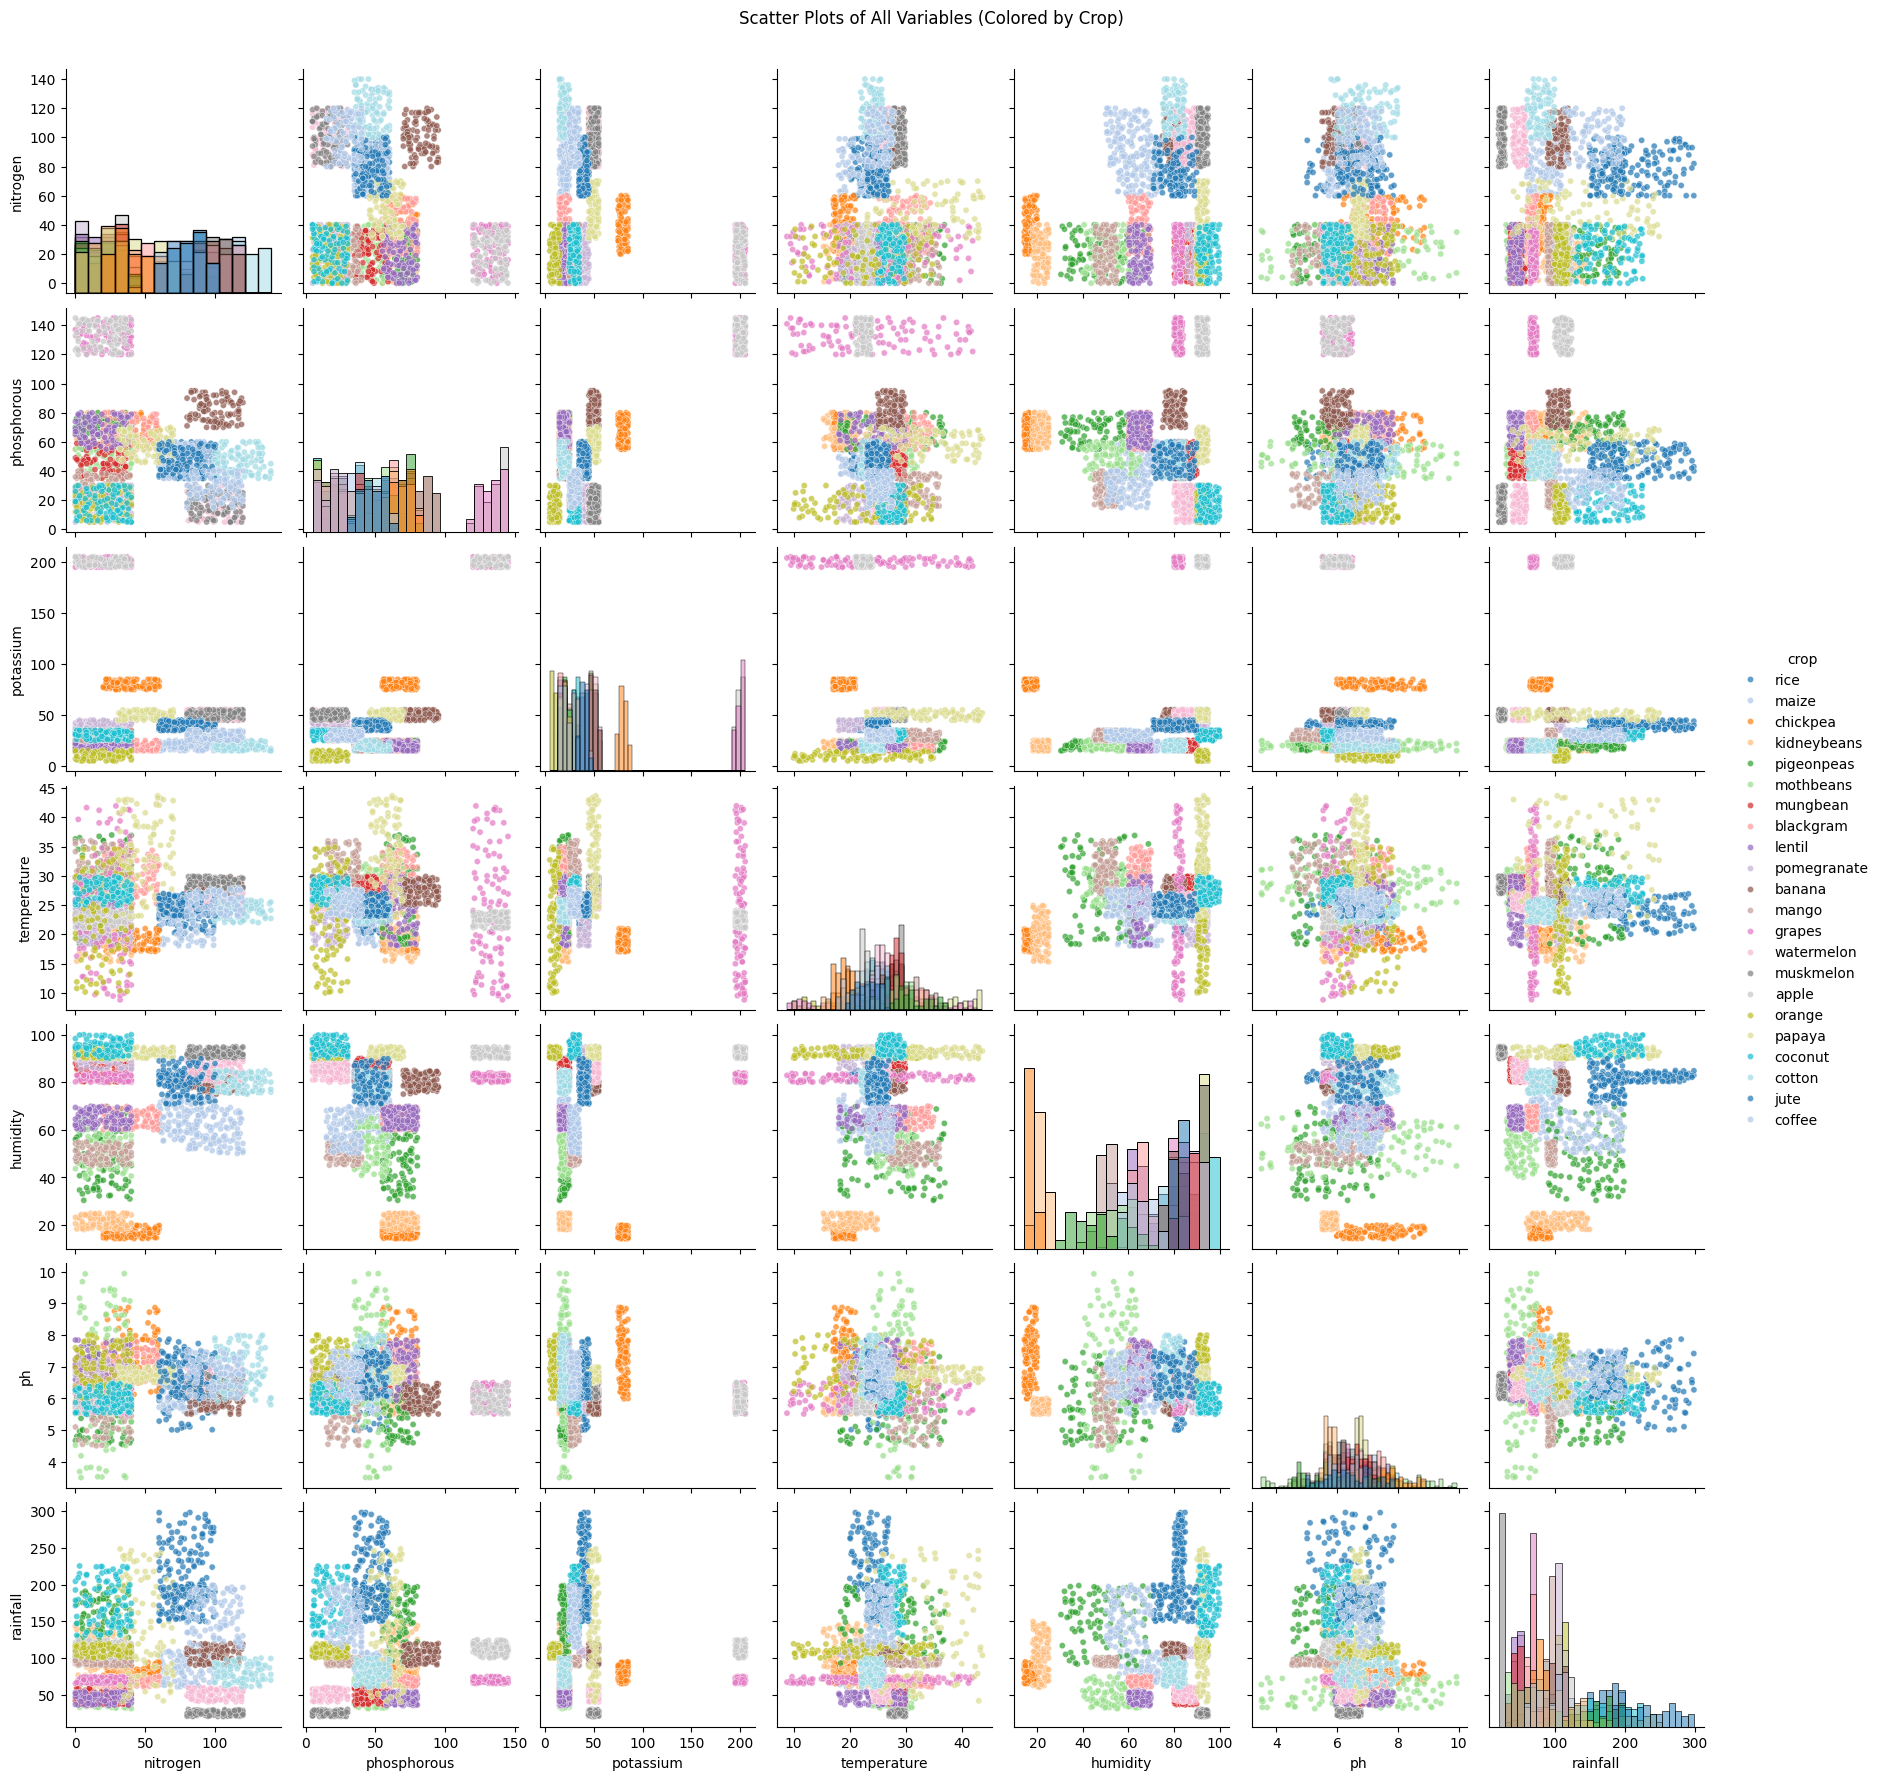

In [95]:
# Scatter plots for all numerical features against each other
sns.pairplot(data, hue='crop', diag_kind='hist', palette='tab20', plot_kws={'alpha': 0.7, 's': 20})
plt.suptitle('Scatter Plots of All Variables (Colored by Crop)', y=1.02)
plt.show()

-> Based on the above we could state that only potassium and phosporous show some level of correlation. Let us check pearsons correlation to confirm this

In [96]:
# Pearsons correlation and p-values to check significance - table view
corr_res = {}

print("Pearson correlation and p-value between numerical features:\n")
for i, col1 in enumerate(numerical_columns):
    for col2 in numerical_columns[i+1:]:
        corr, p_value = pearsonr(data[col1], data[col2])
        if abs(corr) > 0.5:
            corr_strength = "CONSIDERABLE"
        elif abs(corr) > 0.3:
            corr_strength = "SOME"
        else:
            corr_strength = "WEAK / NO"
        significance = "SIGNIFICANT" if p_value < 0.05 else "NOT SIGNIFICANT"
        # Collect results in a dict
        corr_res[(col1, col2)] = {
            'Feature 1': col1,
            'Feature 2': col2,
            'Correlation': corr,
            'P-value': p_value,
            'Strength': corr_strength,
            'Significance': significance
        }

# Convert results to DataFrame and display
corr_df = pd.DataFrame.from_dict(corr_res, orient='index').reset_index(drop=True).sort_values(by='Correlation', key=abs, ascending=False)

print("NOTE: Strength: CONSIDERABLE when abs(corr) > 0.5, SOME when abs(corr) > 0.3, WEAK or NO when abs(corr) <= 0.3")
corr_df

Pearson correlation and p-value between numerical features:

NOTE: Strength: CONSIDERABLE when abs(corr) > 0.5, SOME when abs(corr) > 0.3, WEAK or NO when abs(corr) <= 0.3


,Feature 1,Feature 2,Correlation,P-value,Strength,Significance
6,phosphorous,potassium,0.736232,0.000000e+00,CONSIDERABLE,SIGNIFICANT
0,nitrogen,phosphorous,-0.231460,3.823471e-28,WEAK / NO,SIGNIFICANT
15,temperature,humidity,0.205320,2.274853e-22,WEAK / NO,SIGNIFICANT
12,potassium,humidity,0.190859,1.714900e-19,WEAK / NO,SIGNIFICANT
3,nitrogen,humidity,0.190688,1.848573e-19,WEAK / NO,SIGNIFICANT
13,potassium,ph,-0.169503,1.205751e-15,WEAK / NO,SIGNIFICANT
11,potassium,temperature,-0.160387,3.802198e-14,WEAK / NO,SIGNIFICANT
1,nitrogen,potassium,-0.140512,3.599057e-11,WEAK / NO,SIGNIFICANT
9,phosphorous,ph,-0.138019,7.972631e-11,WEAK / NO,SIGNIFICANT
7,phosphorous,temperature,-0.127541,1.932983e-09,WEAK / NO,SIGNIFICANT


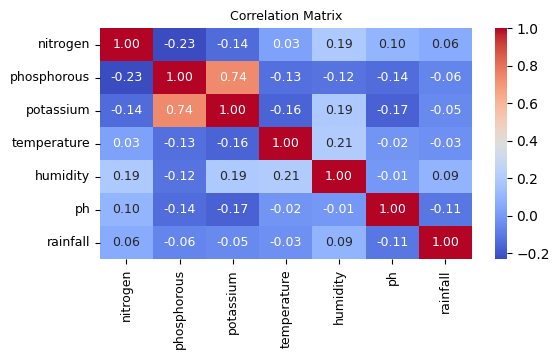

In [97]:
# correlation matrix - for visual comparison
plt.figure(figsize=(6, 3))
correlation_matrix = data[numerical_columns].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    annot_kws={"fontsize": 9}
)
plt.title('Correlation Matrix', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

-> Based on the above analysis we can conclude that Phosphorous and Potassium are strongly correlated. This suggests one of these two features could be removed from the dataset without largely affecting an ML model's predictive power. The reason is that these two features are brining in similar informaiton.

However, given that the overall number of features in this dataset is small, unlike high-dimensional datasets with houndres or thousands of features, there is no strong need to eliminate either one. Overall, whether we retain both or drop one of these two features, it is unlikely to have a significant impact on the model's performance.

### EDA - conclusions

The above EDA analysis demonstrated the following:
> (+) The descriptive statistics did not show anything unusual

> (+) There are no missing values in the dataset

> (+) The features are strongly correlated with the target variable, suggetsing they carry useful predictive information

> (+) The features are not strongly correlated with each other (*apart from some correlation between phosphorous and potessium, which we can neglect as per above conclusion*)

> (+) The data sample is well balanced, i.e. the classes within target variable are uniformly distributed

Overall, we can conclude this is a good quality dataset with strong predictive potential.


As next steps, we will move to train/test split, before performing feature scaling / normalization, given we have observed different scales of features (e.g. raifall vs ph).

# Train / test split

Before we move to feature engineering we will perform train/test split of the data. This is needed to ensure no data leakage occurs. It is also needed to ensure the evaluatin of the model is unbiased, i.e. performed on data that model has not seen so far. This imitates a situation in a future when new data arises and the model needs to make a correct prediction

To perform the train/test split we will use the common train_test_split module from the  sklearn library

In [98]:
# get X and y arrays
X = data.drop(columns=['crop'])
y = data['crop']

In [99]:
# Split the data into training and testing sets
test_split_size = 0.2  # 20% for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=42) # setting random_state for reproducibility

# Data Preprocessing / Feature engineering

### Transforming & scaling

In [100]:
# --> Transformations

# log1p handles zeros
log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])
# simple z-score
standard_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
# Min-max scaling
minmax_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

# ---> ColumnTransformer mapping (as identified in section "Distribution - numerical features")
preprocessor_X = ColumnTransformer(transformers=[
    ("nitrogen", standard_transformer, ["nitrogen"]),
    ("phosphorous", log_transformer, ["phosphorous"]),
    ("potassium", log_transformer, ["potassium"]),
    ("temperature", standard_transformer, ["temperature"]),
    ("humidity", minmax_transformer, ["humidity"]),
    ("ph", standard_transformer, ["ph"]),
    ("rainfall", log_transformer, ["rainfall"])
])
preprocessor_X

,transformers,"[('nitrogen', ...), ('phosphorous', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [101]:
# fit & transform X
X_train_processed = preprocessor_X.fit_transform(X_train)
# transform X test
X_test_processed = preprocessor_X.transform(X_test)

In [102]:
# convert processed features into a df
X_train_processed_df = pd.DataFrame(X_train_processed, columns=numerical_columns)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=numerical_columns)
X_train_processed_df.head(2)

,nitrogen,phosphorous,potassium,temperature,humidity,ph,rainfall
0,-0.903427,-1.362272,-1.181693,-1.804692,0.908990,0.193474,0.263367
1,-0.367051,0.850439,-0.787910,0.386000,0.642579,0.863918,-0.449677


### Label Y

In [103]:
# encode label y
label_encoder_y = LabelEncoder()
y_train_processed = label_encoder_y.fit_transform(y_train)
y_test_processed = label_encoder_y.transform(y_test)

Review the distribution of label within test and train data sets

In [104]:
# Count crop-types in train and test sets
train_counts = y_train.value_counts(normalize=True)
test_counts = y_test.value_counts(normalize=True)
dist_df = pd.DataFrame({'train %': np.round(train_counts*100,1),
                        'test %': np.round(test_counts*100,1)})
dist_df


,train %,test %
crop,,
apple,4.4,5.2
banana,4.5,4.8
blackgram,4.5,4.5
chickpea,4.2,5.9
coconut,4.1,6.1
coffee,4.7,3.9
cotton,4.7,3.9
grapes,4.9,3.2
jute,4.4,5.2


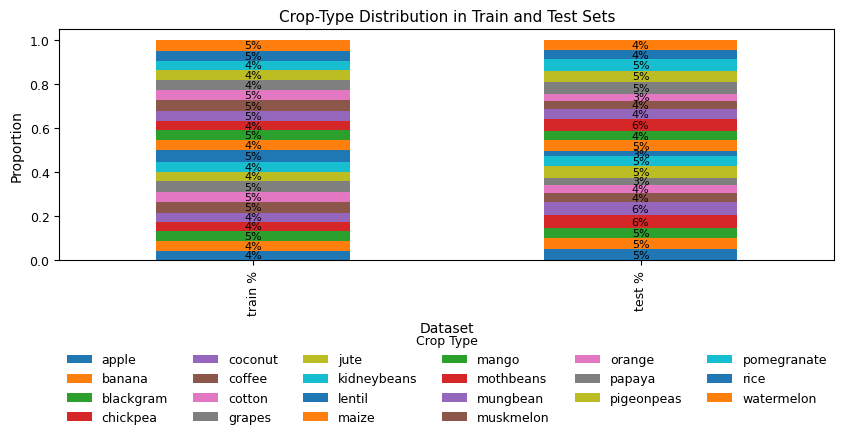

In [105]:
# visualize in bar chart
dist_df_norm = dist_df.div(dist_df.sum(axis=0), axis=1)

dist_df_norm_T = dist_df_norm.T

ax = dist_df_norm_T.plot(kind='bar', stacked=True, figsize=(10, 3))
ax.set_ylabel('Proportion')
ax.set_xlabel('Dataset')
ax.set_title('Crop-Type Distribution in Train and Test Sets', fontsize=11)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', label_type='center', fontsize=8, labels=[f"{v*100:.0f}%" if v > 0 else "" for v in container.datavalues])
ax.legend(title='Crop Type', bbox_to_anchor=(0.5, -0.27), loc='upper center', ncol=6, fontsize=9, title_fontsize=9, frameon=False)
plt.show()


-> The chart above shows that the crop classes are evenly represented in both training and test sets (4-6%), indicating that the split preserved class balance and no significant imbalance is observed.

# Over-/under-sampling

In the EDA analysis (and above) we could see the classes are well balanced. Therefore, no under- or over-sampling techniques needs to be applied. We are moving to cross-validation.

# Model training & validation

## Models Selection

Given our target variables are categorical, we are dealing with classification model. For this we could use a number of models, for instance:
* Logistic Regression
* Decision Tree Classifier
* SVC
* KNN Classifier
* Random Forest Classifier
* Ada Boost Classifier
* Gradient Boost Classifier
* XGBoost Classifier

For our purposes we will use:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Ada Boost Classifier
* Gradient Boost Classifier
* XGBoost Classifier

We have decided not to use SVM as it is computationally expensive and can be challenging to tune. Furthermore, SVMs tend to be more effective in high-dimensional or text classification tasks, where data is sparse and the decision boundary may be highly nonlinear. Similarly, we chose not to use KNN. While KNN is simple an dintuitive, it relies heavily on distance calculation, making it computationally expensive at the prediction time and sensitive to irrelevant features. Since our data has multiple numerical and categorical features, more scalable and robust models as tree ensembles and  logistic regression are more suitable.


In [106]:
# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

## Cross-Validation & Model Evaluation

We will use **stratified cross-validation** to evaluate each model. We use stratified option to ensure that class proportions are preserved across all folds, maintaining balanced datasets.

To find the best model we compute the following **metrics**:
* Accuracy
    * this is the main metric we look at first. Accuracy is a proportion of total predictions that the model got correctly classified
    * Given our classes are balanced there is no need to look at "balanced accuracy", which is more appropriate in the case of class imbalance.
* Macro Recall / Precision
    * These metrics separately summarizes precision and recall across all classes by averageing per-class values.
    * Precision is useful when the cost of a false positive is high. It measures how many instances predicted by the model as positive, where actually positive.
    * Recall is useful when the cost of false negative is high. It measures how many of all actual positive instances the model predicted correctly.
    * We  calculate these, but given we do not have any special requirements for either recall or precision, we will focus instead on the F1 score, which balances both.
* Macro F1
    * F1 is calculated for each class individually and then averaged.
    It balances precision and recall and ensures that each class contributes equally, regardless of its size.

*Note: we will not look at a negative log loss (i.e. Log Loss or Cross-Entropy Loss) as we are not interested in evaluating probabilitic predictions. Instead, we focus on hard class labels identification*

### Cross-validation


In [107]:
# stratifiedKFold with 5 folds to maintain class distribution in each fold
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Metrics definition

In [108]:
# metrics to evaluate model's perdictive power
metrics = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
}

### Models evaluation

In [109]:
# evaluate each model one by one, collate results of each fold, calculate mean and std dev
rows = []
for name, model in models.items():
    # create a pipeline for each model
    pipeline = Pipeline([
        ("preprocessor", preprocessor_X),
        ("classifier", model)
    ])

    # perform cross validation for each model
    result = cross_validate(
        pipeline,
        X_train,
        y_train_processed,
        cv = cross_val,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=False
    )

    # collect means and std dev for scoring metrics
    row = {"model": name}
    for k,v in result.items():
        if k.startswith("test_"):
            row[f"{k.replace('test_','')}_mean"] = v.mean()
            row[f"{k.replace('test_','')}_std"] = v.std()
    
    # collate results
    rows.append(row)

    # turn to a df
    results_df = pd.DataFrame(rows).set_index("model")

    # order columns
    cols_order=[]
    # for col in ["accuracy", "balanced_acc", "f1_macro", "precision_macro", "recall_macro", "neg_log_loss"]:
    for col in ["accuracy", "f1_macro", "precision_macro", "recall_macro"]:
        cols_order += [f"{col}_mean", f"{col}_std"]

    # sort vlaues
    results_df = results_df[cols_order].sort_values("f1_macro_mean", ascending=False)

results_df


,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std
model,,,,,,,,
Random Forest,0.995455,0.001392,0.995398,0.001366,0.995521,0.001343,0.995488,0.001366
Gradient Boosting,0.990341,0.001392,0.990217,0.001468,0.990854,0.001414,0.990310,0.001325
Decision Tree,0.986932,0.003409,0.986770,0.003494,0.987689,0.003102,0.986691,0.003581
XGBoost,0.984659,0.002273,0.984525,0.002305,0.985768,0.002090,0.984791,0.002148
Logistic Regression,0.961364,0.011999,0.960886,0.012531,0.963547,0.012685,0.960950,0.011952
AdaBoost,0.240341,0.083941,0.148430,0.068749,0.129295,0.066620,0.242643,0.082960


-> **Results interpretation**

Overall, the predictive power of developed models is very high (all but AdaBoost), with cross-validated accuracies above 0.96. At first glance, such high scores could suggest overfitting. However, given in the EDA we have seen a strong correlation between feature values and labels, a high performance score was expected. We therefore proceed assuming this is not an oveffiting. Our statement will be validated during final model tests on the unseen data.

Second, tree-based models perform the best, with Random Forest taking the lead: mean accuracy ~0.9949, standard deviation 0.002 (the latter indicatees that the results of each fold are very stable). The Logistic Regression also performs quite well: accuracy of ~0.9614. Given Logistic Regression models are simpler, interpretable, and less computation expensive, it would make this model also a good candidate if explainability and interpretation was the key concern.

In the following section we will perform parameters-hypertuning. We validate if the accuracy of Logistic Regression could match the one of tree-based models and if the accuracy of tree-based model can be further increased. Finally, we skip parameter hypertuning for AdaBoost due to it low predictive power shown in the initial run.

 ## Hyperparameters Tuning

In [64]:
# if trained model exists, load it to take run-time, else run hypertuning
try:
    best_model = joblib.load("../output/best_crop_model.pkl")
    print("Best model loaded from file 'best_crop_model.pkl'.")
except FileNotFoundError:
    print("No saved model found. Running parameters hypertuning")
    # define parameter grids with potential values of hyperparameters
    param_grids = {
        "Logistic Regression": {
            "clf__C": [0.1, 0.3, 1, 3, 10],
            "clf__class_weight": [None, "balanced"],
            "clf__penalty": ["l2"],       # lbfgs supports l2
        },
        "Decision Tree": {
            "clf__criterion": ["gini", "entropy", "log_loss"],
            "clf__max_depth": [None, 5, 10, 20, 40],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5],
        },
        "Random Forest": {
            "clf__n_estimators": [200, 400, 800],
            "clf__max_depth": [None, 10, 20, 40],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ["sqrt", "log2", 0.5],
            "clf__class_weight": [None, "balanced_subsample"],
        },
        "Gradient Boosting": {
            "clf__n_estimators": [200, 400, 800],
            "clf__learning_rate": [0.03, 0.05, 0.1],
            "clf__max_depth": [2, 3, 5],
            "clf__subsample": [1.0, 0.8],
            "clf__max_features": [None, "sqrt"],
        },
        # for XGBoost we use RandomizedSearch to account for a bigger parameters space and thus longer search times
        "XGBoost": {
            "clf__n_estimators": [300, 600, 1000, 1400],
            "clf__learning_rate": [0.02, 0.05, 0.1],
            "clf__max_depth": [3, 4, 6, 8],
            "clf__subsample": [0.7, 0.85, 1.0],
            "clf__colsample_bytree": [0.7, 0.85, 1.0],
            "clf__min_child_weight": [1, 3, 5],
            "clf__reg_lambda": [1, 3, 10],
            "clf__gamma": [0, 1, 3],
        },
    }

    # Search hyperparameter space for each model
    def search_hyperparam_space(model, estimator, parameters):
        pipeline = Pipeline([
            ("preprocessor", preprocessor_X),
            ("clf", estimator)
        ])

        if model == "XGBoost":
            print(f"Randomized Search for model {model}")
            return RandomizedSearchCV(
                pipeline,
                param_distributions=parameters,
                n_iter=40,
                scoring=metrics,
                refit="accuracy",
                cv=cross_val,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
        else:
            print(f"Grid Search for model {model}")
            return GridSearchCV(
                pipeline,
                param_grid=parameters,
                scoring=metrics,
                refit="accuracy",
                cv=cross_val,
                n_jobs=-1,
                verbose=0
            )

    # run all models with 
    best_models = {}
    output_results = []
    for name, model in models.items():
        if name != "AdaBoost": # skipping AdaBoost due to the initial low performance
            print("\n")
            print("-"*20 + f"Tuning: {name}" + "-"*20)
            temp_clf = search_hyperparam_space(name, model, param_grids[name])
            temp_clf.fit(X_train, y_train_processed)

            best_models[name] = temp_clf.best_estimator_

            temp_result_df = pd.DataFrame(temp_clf.cv_results_)
            best_idx = temp_clf.best_index_

            output = {
                "model": name,
                "best_accuracy_cv": temp_clf.best_score_,
                "best_params": temp_clf.best_params_,
            }

            # extract mean + std deviation metrics
            for m in ["accuracy", "f1_macro", "precision_macro", "recall_macro"]:
                mean_key = f"mean_test_{m}"
                std_key = f"std_test_{m}"
                if mean_key in temp_result_df.columns:
                    output[f"cv_{m}"] = temp_result_df.loc[best_idx, mean_key]
                if std_key in temp_result_df.columns:
                    output[f"std_{m}"] = temp_result_df.loc[best_idx, std_key]

            output_results.append(output)

    # convert colated results to a df
    output_summary = pd.DataFrame(output_results).sort_values("best_accuracy_cv", ascending=False).reset_index(drop=True)


No saved model found. Running parameters hypertuning


--------------------Tuning: Logistic Regression--------------------
Grid Search for model Logistic Regression


--------------------Tuning: Decision Tree--------------------
Grid Search for model Decision Tree


--------------------Tuning: Random Forest--------------------
Grid Search for model Random Forest


--------------------Tuning: Gradient Boosting--------------------
Grid Search for model Gradient Boosting


--------------------Tuning: XGBoost--------------------
Randomized Search for model XGBoost
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [72]:
if 'output_summary' in globals():
    from IPython.display import display
    cols_order = ["model","best_accuracy_cv","cv_f1_macro","cv_precision_macro","cv_recall_macro","std_accuracy","std_f1_macro","std_precision_macro","std_recall_macro","best_params"]
    display(output_summary[cols_order])

,model,best_accuracy_cv,cv_f1_macro,cv_precision_macro,cv_recall_macro,std_accuracy,std_f1_macro,std_precision_macro,std_recall_macro,best_params
0,Random Forest,0.996023,0.996001,0.996149,0.996090,0.001392,0.001307,0.001253,0.001314,"{'clf__class_weight': None, 'clf__max_depth': ..."
1,Gradient Boosting,0.994886,0.994872,0.995235,0.995016,0.003769,0.003803,0.003389,0.003656,"{'clf__learning_rate': 0.03, 'clf__max_depth':..."
2,XGBoost,0.993182,0.993181,0.993468,0.993236,0.002273,0.002350,0.002308,0.002316,"{'clf__subsample': 0.85, 'clf__reg_lambda': 1,..."
3,Decision Tree,0.988068,0.987937,0.988814,0.987941,0.005794,0.005923,0.005279,0.006078,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
4,Logistic Regression,0.976136,0.975890,0.977771,0.975853,0.011163,0.011447,0.011488,0.011283,"{'clf__C': 10, 'clf__class_weight': None, 'clf..."


# Model Testing - Best Model Selection

In [73]:
# best_model
if 'best_model' not in locals() or best_model is None:
        best_model_name = output_summary.loc[0, "model"]
        best_model = best_models[best_model_name]
        print(f"Best model selected: {best_model_name}")
best_model

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nitrogen', ...), ('phosphorous', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
# use the best model to predict on the test set
y_pred = best_model.predict(X_test)

# calculate metrics
test_accuracy = accuracy_score(y_test_processed, y_pred)
test_f1_macro = f1_score(y_test_processed, y_pred, average="macro")
test_precision_macro = precision_score(y_test_processed, y_pred, average="macro")
test_recall_macro = recall_score(y_test_processed, y_pred, average="macro")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")
print(f"Test Precision Macro: {test_precision_macro:.4f}")
print(f"Test Recall Macro: {test_recall_macro:.4f}")

Test Accuracy: 0.9932
Test F1 Macro: 0.9926
Test Precision Macro: 0.9926
Test Recall Macro: 0.9933


-> As per above results we can see that the accuracy of the model as well as the F1 score is very high, even for the test data. **We can therefore say that the current Random Forest model is a strong predictor**

# Model Interpretation

In order to better understand the model we will first look at **Feature Importance** (Gini Importance), which helps to undertand how much each feature reduces impurity across all trees. In other words, which feature has the biggest impact on predicting the right class of the target variable.

Secondly, we will look at **Permutation Importance**, which measures the degradation in model performance when each feature's values are randomly shuffled. This metric also measures how important a feature is for making the right prediction, and it is more reliable than the Gini Importance, especially when dealing with correlated features.

## Feature Importance

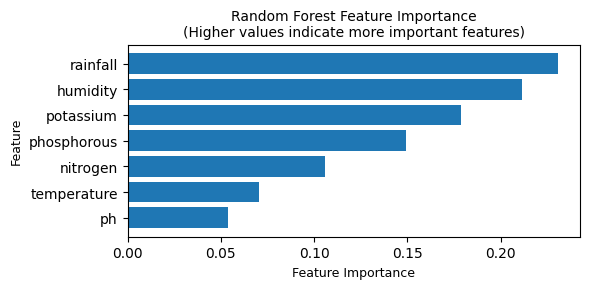

Feature Importance (Random Forest):


,feature,importance,cumulative_importance
6,rainfall,0.2309,0.2309
4,humidity,0.2114,0.4424
2,potassium,0.1786,0.6209
1,phosphorous,0.1490,0.7699
0,nitrogen,0.1058,0.8757
3,temperature,0.0707,0.9464
5,ph,0.0536,1.0000


In [75]:
# get feature importances
feature_importances = best_model.named_steps['clf'].feature_importances_
feature_names = numerical_columns.tolist()

# transfortm into df
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

# visualize feature importance
plt.figure(figsize=(6, 3))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance', fontsize=9)
plt.ylabel('Feature', fontsize=9)
plt.title('Random Forest Feature Importance\n(Higher values indicate more important features)', fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature Importance (Random Forest):")
importance_df.round(4)

-> **Interpretation**

* Rainfall and Humidity - both of which are climate features - are the two most important factors in determining the best crop to grow. These two features contribute together ~44% of predictive power.
* Potassium phosporus, nitrogen - which are soil features - have a similar importance all together: ~43.4% (87.6 - 44.2). This indicates that managing soil fertility is nearly as important as managing water-related factors.
* Temperature and Ph - these variables contributed less than expected, with individual importances of around 5-7%..

The above suggest that water management - rainfall & humidity - is the primary consideration. Farmes should first assess water availability and humidity, followed by soil nutrient levels, before making a decision about a crop.

## Permutation Importance

Permutation Importance Mean - smallest to largest - (Train Set):
[0.00920455 0.01329545 0.09801136 0.16045455 0.20147727 0.205
 0.31551136]
['temperature', 'ph', 'phosphorous', 'potassium', 'nitrogen', 'rainfall', 'humidity']

Permutation Importance Mean - smallest to largest - (Test Set):
[0.01272727 0.01295455 0.10590909 0.17       0.18590909 0.21181818
 0.33568182]
['ph', 'temperature', 'phosphorous', 'potassium', 'rainfall', 'nitrogen', 'humidity']


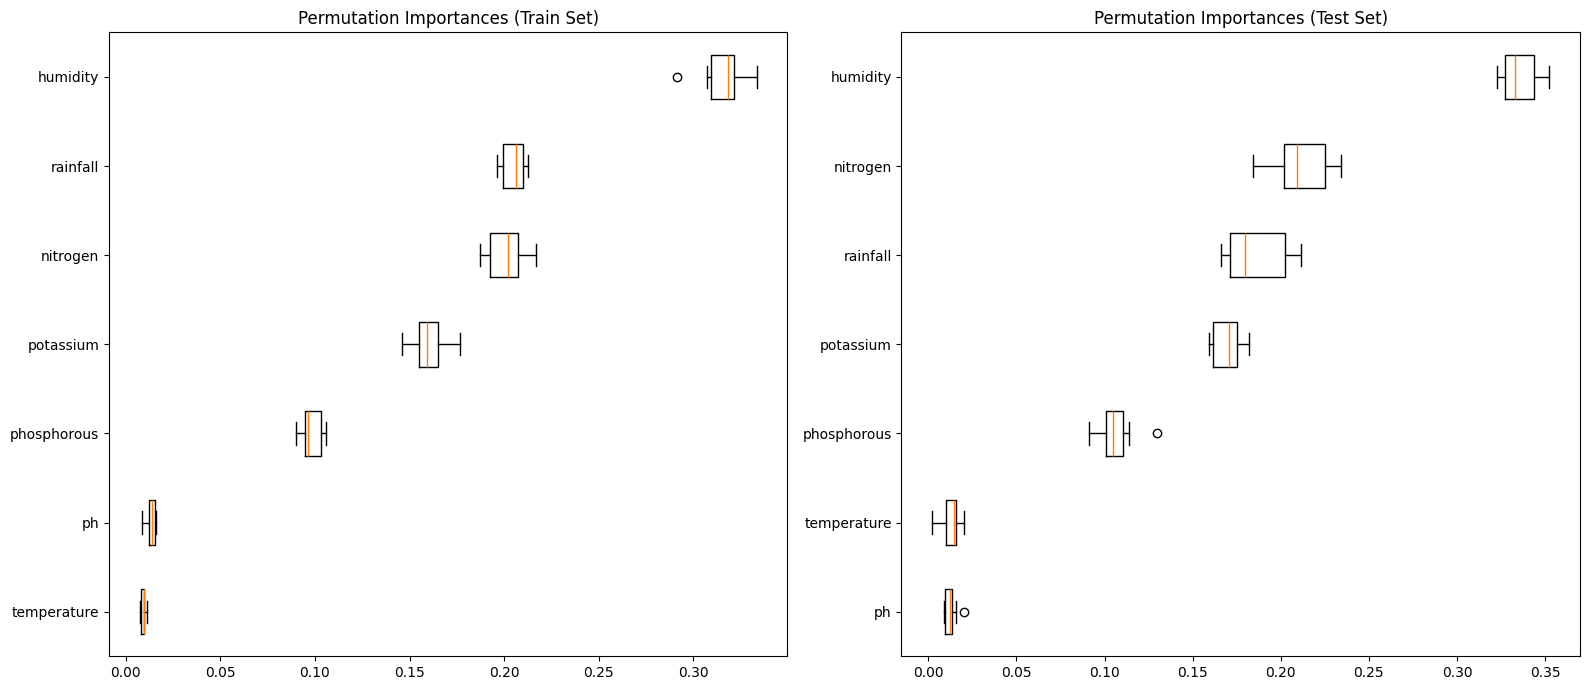

In [76]:
# permutation importance for train and test sets

# train set
perm_train = permutation_importance(
    estimator=best_model,
    X=X_train,
    y=y_train_processed,
    n_repeats=10,
    random_state=1,
    n_jobs=2
)
train_sorted_idx = perm_train.importances_mean.argsort()#[::-1]
train_feature_names_sorted = numerical_columns[train_sorted_idx]

# test set
perm_test = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test_processed,
    n_repeats=10,
    random_state=1,
    n_jobs=2
)
test_sorted_idx = perm_test.importances_mean.argsort()#[::-1]
test_feature_names_sorted = numerical_columns[test_sorted_idx]

print("Permutation Importance Mean - smallest to largest - (Train Set):")
print(perm_train.importances_mean[train_sorted_idx])
print(list(numerical_columns[train_sorted_idx]))
print("\nPermutation Importance Mean - smallest to largest - (Test Set):")
print(perm_test.importances_mean[test_sorted_idx])
print(list(numerical_columns[test_sorted_idx]))

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ax1.boxplot(
    perm_train.importances[train_sorted_idx].T,
    vert=False,
    tick_labels=train_feature_names_sorted
)
ax1.set_title("Permutation Importances (Train Set)")

ax2.boxplot(
    perm_test.importances[test_sorted_idx].T,
    vert=False,
    tick_labels=test_feature_names_sorted
)
ax2.set_title("Permutation Importances (Test Set)")

fig.tight_layout()
plt.show()


-> Intepretation:
Permuation Importance shows how much a model performance degrades when a feature's values are randomly shuffled. If shuffling a feature significantly reduces accuracy, that feature is considered important.

The boxplot above shows these results across multiple permutations that were run. From these charts we can conclude the following:
* The relative importance of each feature is quite similar when looking at train and test data. This means there is a stability across the two datasets, meaning our model is not overfitting.
* The feature that has the highest impact on the model performance is Humidity (>30%). We can see this in both test and train dataset. Additonally the standard deviation is low, indicating a strong and stable contribution to the model performance.
* Rainfall, Nitrogen, Potassium and Phosphorous have all similar impact (~10-20%). 
* Temperature and Ph are the two features that have very small impact on the model performance (both ~0.01)

These conclusinos align with the obvervations we made when looking at Feature Importance output, although we can see that humidity is the dominating feature.

# Final Results

### **Main Takeaways**

This project confirms that machine learning can accurately recommend suitable crops based on soil and climate data. The most important factors are water-related variables (humidity and rainfall), followed closely by soil nutrients like potassium and nitrogen. Simpler models like Logistic Regression also perform well and may be preferred when interpretability is required. From an agricultural standpoint, managing water availability and monitoring key soil nutrients are essential for informed crop decisions.


### **Model Performance Summary**

>**Baseline**

The following models were trained and evaluated using stratified cross-validation:

| Model                 | Mean Accuracy | Std Dev (Accuracy) | Notes                               |
|----------------------|---------------|--------------------|-------------------------------------|
| Random Forest        | **0.9955**    | 0.001              | Best performing, very stable        |
| Logistic Regression  | 0.9614        | 0.012              | Simpler, interpretable              |
| AdaBoost             | 0.2403        | 0.084              | Underperformed, not tuned further   |

All models (except AdaBoost) achieved very high accuracy scores. The **Random Forest model** was the best performer, showing both very high accuracy and consistency across folds. **Logistic Regression** also performed well and offers benefits like interpretability and computational efficiency.

>**Tuned results (hyperparameters optimized)**

Hyperparameters tuning confirmed insights gathered during the baseline model performance evaluation. **Random Forest** performed the best achieving **99.6% accuracy** and strong F1-macro on the test set. **Logistic Regression** reached **97.6% accuracy**.  

These high scores are **supported by strong relationships** between the features and crop labels, as shown in the EDA and confirmed by permutation importance and feature importance plots. Variance across folds was minimal, suggesting **low risk of overfitting**.



### **Feature Insights**

From permutation and model-based feature importance analyses:

- **Humidity** emerged as the most critical factor (importance ~0.30).
- **Rainfall, Nitrogen, and Potassium** followed closely (importance ~0.21 each).
- **Temperature and pH** had very low contributions (~0.01), indicating less relevance in distinguishing crop types.

These findings suggest that **water-related features and nutrient availability** are the primary determinants of crop suitability. And that temperature and pH is equally suitable for all crops.

### **Practical Implications**

Based on the model results and interpretation:

- **Water management** (rainfall & humidity) is the most critical lever for crop selection.
- **Soil testing**, especially for **potassium and phosphorus**, is also important.
- **Temperature and pH**, are less useful for prediction - likely due to the low variance across crops.

Agricultural recommendations:
- Prioritize irrigation systems and moisture management, especially in regions with low natural rainfall.
- Promote affordable soil testing kits to help farmers monitor potassium and nitrogen levels.
- Use crop recommendation tools to advise farmers before each planting season, factoring in local weather and soil reports.
- Consider mobile-based deployment of this model to reach rural farmers with limited internet access.

### **Future Work**

- Validate the model on external datasets from other regions to assess generalizability.
- Integrate real-time weather and satellite data for dynamic, location-specific recommendations.
- Expand the model to recommend **multi-crop rotations** for long-term planning.
- Collaborate with agricultural stakeholders (e.g., NGOs, cooperatives) to test field-level deployment.
- Explore mobile-based delivery to increase accessibility in rural or low-connectivity areas.


### **Conclusions**

By combining machine learning with agronomic domain knowledge, this project demonstrates how data-driven crop recommendation systems can guide farmers toward more efficient and sustainable agricultural decisions. With real-world validation and thoughtful deployment, this tool has the potential to significantly enhance yield outcomes and resource optimization.

# Saving the best model

In [77]:
preprocessor_file = "../output/crop_preprocessor.pkl"
if not os.path.exists(preprocessor_file):
    with open(preprocessor_file, "wb") as file:
        pickle.dump(preprocessor_X, file)
    print(f"Preprocessor saved successfully to '{preprocessor_file}'")
else:
    print(f"Preprocessor file '{preprocessor_file}' already exists.")

# Save the trained model to a file so it can be used later for predictions
model_file = "../output/best_crop_model.pkl"
if not os.path.exists(model_file):
    with open(model_file, "wb") as file:
        pickle.dump(best_model, file)
    print(f"Model saved successfully to '{model_file}'")
else:
    print(f"Model file '{model_file}' already exists.")

Preprocessor saved successfully to '../output/crop_preprocessor.pkl'
Model saved successfully to '../output/best_crop_model.pkl'
